# Week 2. Linear Regression (McElreath Ch. 4)

__Probabilistic Programming. Wąsowski. Pardo. IT University of Copenhagen__

This example and some figures are is from 
* Based on McElreath, Chapter 4
* Some inspiration from: Kruschke. _Doing Bayesian Data Analysis. A tutorial with R, JAGS, and STAN._ 2nd Ed.

Adaptations of R examples to PymC courtesy of https://github.com/pymc-devs/resources/tree/master/Rethinking_2 (with our own modifications)

In [ ]:
import pymc as pm
from pytensor import shared
import numpy as np
import arviz as az
import xarray as xr # used by pymc to represent inference data
import pandas as pdw
import rethinking as rt
import scipy.stats as stats
import textwrap
from matplotlib import pyplot as plt
az.style.use("arviz-darkgrid")

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
hdi_fill_args = { 'color': 'black', 'alpha': 0.1 }

<br/><br/><br/><br/><br/>

# Goals

* How to do **linear regression and prediction** the "Bayesian" way?
* Is my Bayesian model **correct**?

<br/><br/><br/><br/><br/>

# Outline

* __Gaussian__ Density Function
* Bayesian model of a __Linear Regression__
* __Prior-predictive__ check (how do we select priors?)
* __Posterior inference & analysis__ (interpreting the regression results)
* __Posterior-predictive__ check (is the posterior sane?)
* Using the posterior for __prediction__

<br/><br/><br/><br/><br/>

# Normal Density
* Probably the most well known probability distribution
* Typically, what we call a normal/gaussian distribution is actually a **probability density** function. What does this mean?

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(6, 4))
μ = 0.0
σ = 0.2
grid = np.linspace(-0.7, 0.7, 100)
# scipy uses `loc` for mean and `scale` for standard deviation
values = stats.norm.pdf(grid, loc = μ, scale = σ)
plt.plot(grid, values, label=f'Normal (μ={μ}, σ={σ})', color='black')
plt.fill_between(grid, values, color='black', alpha=0.1, label='Shaded Area')
plt.xticks(np.linspace(-0.6, 0.6, 7)) 
plt.xlabel('x')
plt.ylabel('p(x)')
plt.text(-0.2, 1.7, 'μ = 0.0', fontsize=12, ha='right')
plt.text(-0.2, 1.5, 'σ = 0.2', fontsize=12, ha='right')
plt.text(0.0, 0.5, '1', fontsize=30, ha='center')
plt.show()

$$
p(x \mid \mu, \sigma) = 
{1 \over \sigma \sqrt{2\pi}} 
\exp 
\left(-{1\over 2} \left[{x - \mu \over \sigma}\right]^2 \right)
$$


* μ - **mean**, AKA location, defines where the bell has the top (mode)
* σ - **standard deviation**, AKA scale, controls how narrow the bell is
* $\exp(x)$ is just the exponential function $e^x$
* All values of $x\in\mathbb{R}$ have positive probability density
    * The support of the distribution is $(-\infty, +\infty)$

<br/><br/><br/><br/><br/>

### Why is the Normal distribution important?

* Normal distributions arise when you __add together small fluctuations__ which tend to cancel
* (e.g., symmetric measurement errors, people having/not having opportunity/genetics to grow, etc.)
* A normal distribution is a __maximum entropy__ distribution with given mean and variance.
* It adds no extra information or bias if you only know mean and variance
* Thus it can be used to estimate mean and variance, even if your data is not normally distributed.
* __Carl Friedrich Gauss__ has introduced this distribution in his proposal of linear regression, early 19th century
* All statistics was Bayesian back then, so __his original argument is Bayesian__ (or based on probability theory).

<br/><br/><br/><br/><br/>

$$
p(x \mid \mu, \sigma) = 
{1 \over \sigma \sqrt{2\pi}} 
\exp 
\left(-{1\over 2} \left[{x - \mu \over \sigma}\right]^2 \right)
$$


**Digression:** consider $\log(p(x))$
* Notice that this is a quadratic function.
* This explains the name _quadratic approximation_ (which uses the Gaussian)
* The method operates on the logarithm of the density function (which is very common)
* $(x - \mu)^2$ is a quadratic function, its exponentiation had the familiar bell curve
* The rest is just normalization terms

<br/><br/><br/><br/><br/>

An alternative parameterization of Gaussian distribution
$$
p(x \mid \mu, \tau) = 
\sqrt{\tau \over 2\pi} \exp\left(-{1 \over 2} \tau \left(y - \mu\right)^2\right)
$$

* $\tau$ is called **precision** and it is defined as the inverse of the variance: $\tau = 1/\sigma^2$
* This form is sometimes used by libraries, so it is good to remember that it exists, and how to switch between $\tau$ and $\sigma$

<br/><br/><br/><br/><br/>

# A Caveat: Geocentric models

* McElreath speaks of regression in a somewhat deamning way: it is like a geocentric model of planet motion of Ptolemy. Using a Fourier series it can approximate planet motion in the solar system arbitrary well, so it can **predict**, but it cannot **explain**.
* This is a problem with most of statistics, and thus in later chapters we are moving towards casual models.
* Regression is still **useful**, if prediction is the only thing you need, or if you can combine it with other inference and modeling methods.

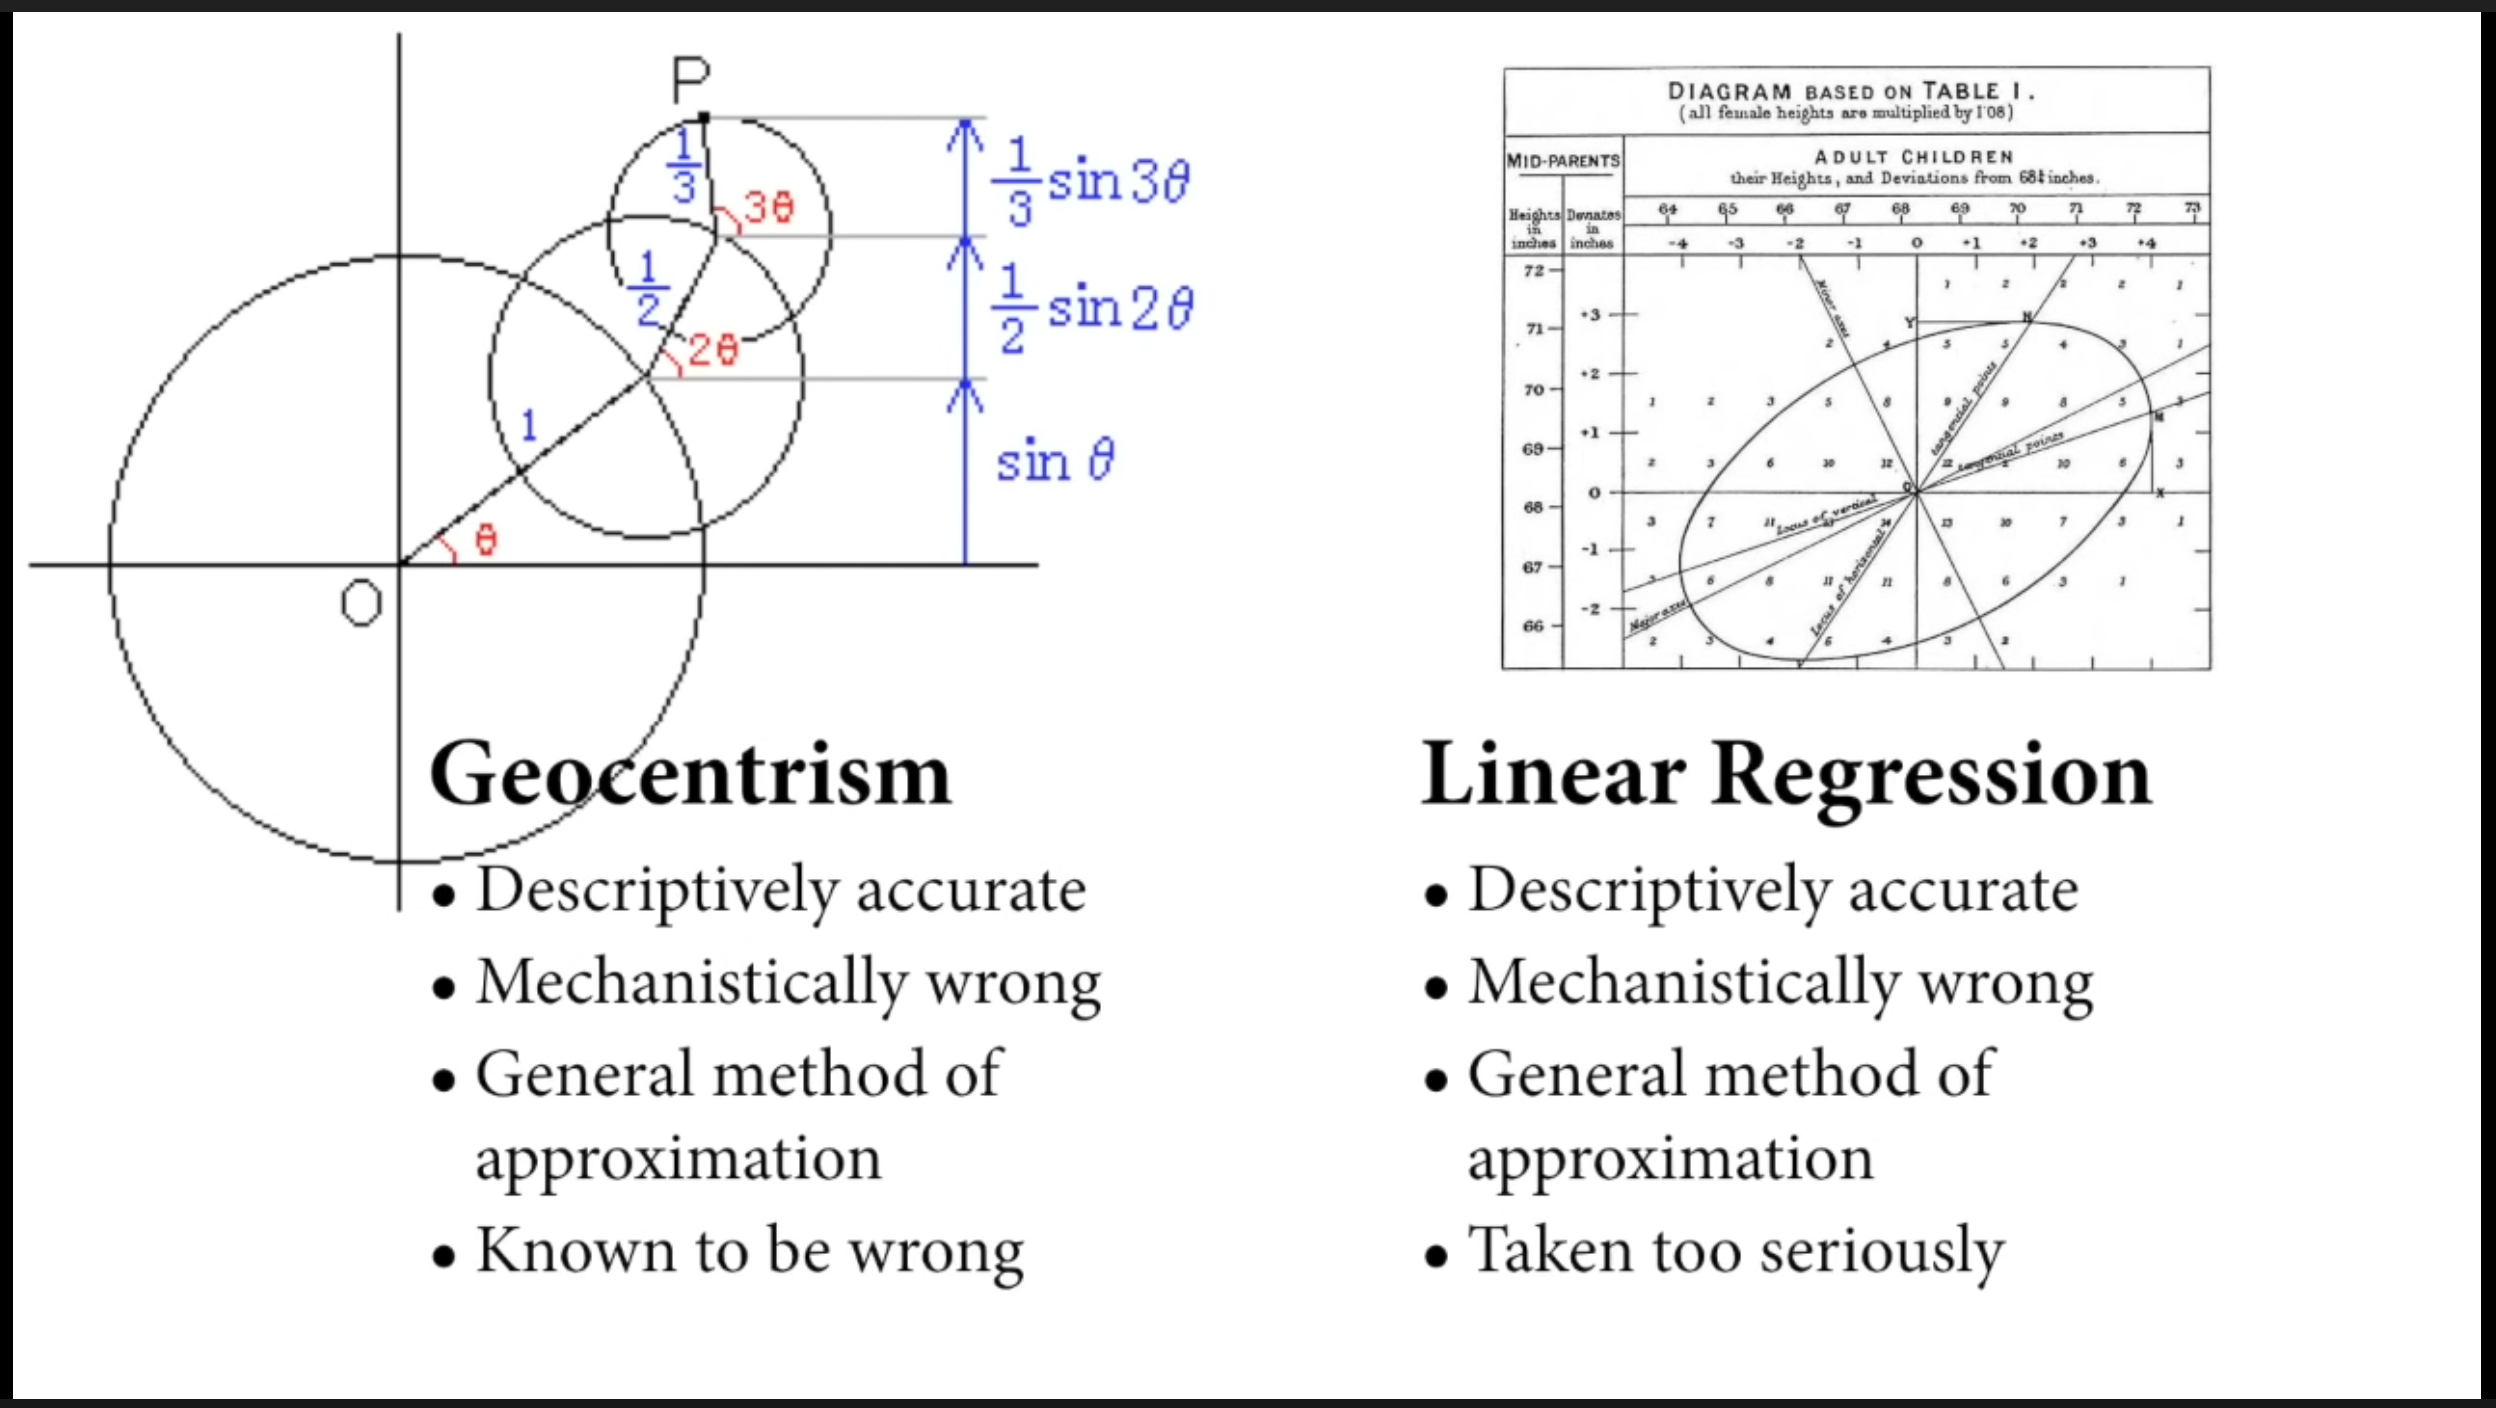
(c) Richard McElreath

<br/><br/><br/><br/><br/>

# Linear Regression

* We work with a set of **variables**
* The __observable__ variables are reflected in __data__ (we often call them data)
* The __unobservable__ variables are called parameters (rates, averages, etc., things we want to infer)
* The parameters are defined in terms of the other variables or in terms of a probability distribution, depending on what we know about them up-front.
* The combination of parameters and the distributions defines a __generative model__, which we can use to make __predictions__ (simulate hypothetical situations) and to analyze data (reality)

<br><br>

* __Predicted__ variable: what we want to predict (one of the data variables, the ground truth value, which we would like to learn to predict, typically)
* __Predictor__ variables: the input to the prediction (one of the data variables, which is easy for us to measure, thus we would like to base the prediction on it)

<br/><br/><br/><br/><br/>

# Bayesian Linear Regression

Bayesian linear regression is just posterior analysis
* We use __priors__ to define the basic info about parameters, and use __posterior__ analysis to understand how the data influences this basic info.
* This allows us to investigate corelations in the data, and __fit arbitrary complex functions__.
* The choice of __linear function__ is completely arbitrary, and often incorrect (and with modern technology we don't have to stick to linear models), but let's start somewhere.
* Below we build a model for __predicting the height of an adult human from their weight__.

<br/><br/><br/><br/><br/>

# Example (1): Linear Regression for Weight and Height

* "Suppose we have been able to collect heights and weights from ```size``` adults sampled at random from a population of interest."

* Heights are measured on the continuous scale of cm

* Weights are measured on the continuous scale of kg

* We wish to predict weight from height

* We begin by declaring a sample `size` then loading the data to be analyzed, fixing the types, and showing the prefix of the data so that you know what is in the file.  Feel free to inspect the CSV file in a text editor.  Incidentally, you can also open it in Jupyter Lab, which displays CSV files in a tabular format.

<br/><br/><br/><br/><br/>

# Example (2): Read and Understand the Data

We always start with the basics stats and basic data plots to get an idea of what data are we dealing with.

In [ ]:
def summarize(ds: xr.Dataset, var1: str, var2: str, unit1: str, unit2: str):
  # we produce summary stats using our own re-implementation of precis (of the R book package)
  print(textwrap.indent(f"\n\n{rt.precis(ds)}\n", '      '))
  _, ax = plt.subplots(figsize = (4.5, 3))
  ds.plot.scatter(x = var1, y = var2, color="black", s=20, alpha=0.15, ax = ax) 
  ax.set_xlabel(f"{var1} in {unit1}", fontsize=10)
  ax.set_ylabel(f"{var2} in {unit2}", fontsize=10)
  ax.tick_params(axis='both', which='both', labelsize=8)
  plt.show()

In [ ]:
data = pd.read_csv('Howell1.csv', sep=';').to_xarray()
summarize(data, 'weight', 'height', 'kg', 'cm')

In [ ]:
adults = data.where(data.age >= 18, drop = True)
summarize(adults, 'weight', 'height', 'kg', 'cm')

<br/><br/><br/><br/><br/>

We seem to have some nonlinear behavior, so let's (for now) focus only on adult individuals.

* Our __goal__ is to predict height from person's weight (it is plausible that these are correlated).
* The data set gives us _ground truth_ to train a model, which we can later use for prediction.

<br/><br/><br/><br/><br/>

In [ ]:
import rethinking as rt
adults = data.where(data['age'] >= 18, drop=True)
print(textwrap.indent(f"\n\n{rt.precis(adults)}\n", '      '))
adults

# Example (3): Modeling, McElreath Section 4.4

* We are assuming a **linear model**:

\begin{align}
h_i    & \sim \mathcal N (\mu_i, \sigma)         & \quad [\,\text{likelihood}\, h \text{ predicted var}]   \\
\mu_i  & =    \alpha + \beta(x_i - \overline x)  & \quad [\,\text{linear model}\, x \text{ predictor}] \\
\alpha & \sim \mathcal N (178, 20)               & \quad [\,\alpha \text{ prior, parameter}\,]        \\
\beta  & \sim \mathcal N(0, 10)                  & \quad [\,\beta  \text{ prior, parameter}\,]        \\
\sigma & \sim \mathrm{Uniform}(0, 50)            & \quad [\,\sigma \text{ prior, parameter}\,]
\end{align}

* For each individual $i \in 1.. 352$, assume that their weight is normally distributed with a different mean. (the __likelihood__ is Gaussian, we will use it to obtain a posterior given the data we are seeing)
* So there is some noise in each person's height, but they are all distributed with the same deviation from the mean.
* Note that when maximizing likelihood, we will be trying to minimize the noise (as the Gaussian has highest density around the mean)
* The mean is linearly dependent on the weight. Note the equality. This is not a probabilistic dependency.  The model predicts the _expected_ height ($\mu_i$) and then allows some noise around it.
* $\alpha$ captures the expected height for average weight (**intercept**)
* $\beta$ accounts for deviations in height, when you deviate in weight (**slope**).
  - What is the deviation from average height (in cm) when you deviate by 1 unit of weight (kg)?
* We control the model by varying $\alpha$ and $\beta$.  The training of the model is learning what are the most likely values for $(\alpha, \beta)$ - so the shape of their  (bivariate) distribution.

__Question:__ How many predictor variables? How many predicted variables? How many parameters in this model?

<br/><br/><br/><br/><br/>

# Example (4): Did we choose the right priors?

* Choosing priors requires special attention in Bayesian data analysis
* Priors informed by data may be seen as **cheating**: you cannot make statistical conclusions if you hack the conclusion into your assumptions (prior)
  - Informing priors by data is a malpractice similar to $p$-hacking in frequentist statistics 
* Priors ignoring reality are nonsensical. We have priors to inform the model about the basic realities that are already known to us.
  
\begin{align}
\alpha & \sim \mathcal N (178, 20)               & \quad [\,\alpha \text{ prior}\,]        \\
\beta  & \sim \mathcal N(0, 10)                  & \quad [\,\beta  \text{ prior}\,]        \\
\sigma & \sim \mathrm{Uniform}(0, 50)            & \quad [\,\sigma \text{ prior}\,]
\end{align}

* The prior for $\alpha$ is chosen by McElreath because he is 178cm
    - 138cm to 218cm is range with 98% probability mass in the prior. This seems to cover a good range of plausible mean heights for a person of average weight.
* The prior for $\sigma$ is just a broad range, even unrealistically broad. A standard deviation of +/- 50cm means +/- 100cm deviations with 95% probability.
    - This seems to capture how people of the same weight differ in height (and larger differences are allowed, just small likelihood)

<br/><br/><br/><br/><br/>

* The $\beta$ prior warrants more discussion.
\begin{align}
\beta  & \sim \mathcal N(0, 10)                  & \quad [\,\beta  \text{ prior}\,]
\end{align}
* When $\beta = 0$ there is no relation between the weight and height
* The prior is symmetric, so allows both positive and negative relationships
* It is a good idea to plot it, to understand whether it is reasonable, but not overfitting.

In [ ]:
# Generate Nlines random lines from the prior
Nlines = 200
a = stats.norm.rvs(loc=178, scale=20, size = Nlines)
b = stats.norm.rvs(loc=0,   scale=10, size = Nlines)
pairs = list(zip(a, b))

# Now plot
x = np.linspace(30, 65, 100)
xbar = adults.weight.data.mean()
for a, b in pairs:
    values = a + b*(x - xbar)
    plt.plot(x, values, color = 'black', alpha = 0.1)
    

plt.title('prior with β ~ N(0,10)', fontsize='medium')
plt.xlabel('x (weight)', fontsize='medium')
plt.ylabel('μ (height)', fontsize='medium')
plt.ylim(-110, 420)
plt.tick_params(axis='both', labelsize='small')
plt.axhline(0, color='black', linestyle='--', linewidth = .5)
plt.axhline(272, color='black', linestyle='--', linewidth = .5)
plt.text(40, 15, 'embryo', fontsize='small')
plt.text(40, 280, "World's tallest person (272cm)", fontsize='small')
plt.show()

* It appears that we allow some crazy priors, like people weighing ~37kg having zero height.
* Also we allow people getting smaller, while getting heavier - this counters our intuition
* One way is to ensure that only non-negative values of $\beta$ are allowed. We can do it by distributing it according to Log-normal distribution (more on log-normals later).

$$\beta \sim \textrm{Log-Normal}(0,1)$$

* This means that the logarithm of $\beta$ is normally  distributed (which makes $\beta$ only take positive values)
* Instead of doing the math, let plot what kind of prior we have:

In [ ]:
# Generate Nlines random lines from the prior
Nlines = 200
a = stats.norm.rvs(loc=178, scale=20, size = Nlines)
b = stats.lognorm.rvs(s=1, scale=np.exp(0.0), size=Nlines)
pairs = list(zip(a, b))

# Now plot
x = np.linspace(30, 65, 100)
xbar = adults.weight.data.mean()
for a, b in pairs:
    values = a + b*(x - xbar)
    plt.plot(x, values, color = 'black', alpha = 0.1)
    

plt.title('prior with β ~ Log-Normal(0,1)', fontsize='medium')
plt.xlabel('x (weight)', fontsize='medium')
plt.ylabel('μ (height)', fontsize='medium')
plt.ylim(-110, 420)
plt.tick_params(axis='both', labelsize='small')
plt.axhline(0, color='black', linestyle='--', linewidth = .5)
plt.axhline(272, color='black', linestyle='--', linewidth = .5)
plt.text(40, 15, 'embryo', fontsize='small')
plt.text(40, 280, "World's tallest person (272cm)", fontsize='small')
plt.show()

* This looks much more reasonable now.
* What we just did was a **prior predictive analysis**
  - We used the joint prior distribution to make predictions from weight to height, and we checked whether they are broadly consistent with our prior knowledge/expectations.
  - We did not use the data yet. We will use it to revise our broad prior with new information.
  - The above implementation is manual. Once we have built a PyMC model for posterior inference, the library also supports prior predictive samples.  So normally we do not need to implement it separately, but also use PyMC for the task. See below.

<br/><br/><br/><br/><br/>

# Example (5): Modeling with PyMC

* This is very similar to the R model from the book, and closely follows the mathematically formulated model above
* One difference is ordering: in Python we have to define the model from priors to likelihood, so that we always refer to the model elements that are defined above (before), not below (after) a line.

In [ ]:
with pm.Model() as m4_3:

    # Prior
    α = pm.Normal('α', mu = 178, sigma = 20) 
    β = pm.LogNormal('β', mu = 0, sigma = 1)
    σ  = pm.Uniform('σ', 0, 50)
    
    # Ignore for now, think of it as x. We could have used x, but this allows to do prediction later.
    x_mutable = pm.Data("x", adults.weight.values)
    
    # The linear model
    μ = pm.Deterministic('μ', α + β*(x_mutable-xbar))
    
    # The likelihood:
    height = pm.Normal('height', mu = μ, sigma = σ, observed = adults.height.data) 

\begin{align}
h_i    & \sim \mathcal N (\mu_i, \sigma)         & \quad [\,\text{likelihood}\, h \text{ predicted var}]   \\
\mu_i  & =    \alpha + \beta(x_i - \overline x)  & \quad [\,\text{linear model}\, x \text{ predictor}] \\
\alpha & \sim \mathcal N (178, 20)               & \quad [\,\alpha \text{ prior, parameter}\,]        \\
\beta  & \sim \textrm{Log-Normal}(0,1)           & \quad [\,\beta  \text{ prior, parameter}\,]        \\
\sigma & \sim \mathrm{Uniform}(0, 50)            & \quad [\,\sigma \text{ prior, parameter}\,]
\end{align}

* We are using the `with` statement (see https://docs.python.org/3/reference/compound_stmts.html#the-with-statement). 
  - Quoting:  *The with statement is used to wrap the execution of a block with methods defined by a context manager*. 
  - In some weird sense it is "monadic Python", whatever that means (https://stackoverflow.com/questions/7131027/is-pythons-with-monadic). 
  - Basically it sets a state object that is going to hold the library state. A more palatable introduction to `with`: https://preshing.com/20110920/the-python-with-statement-by-example/ . 
  - In pymc the `with` construct allows to work with more than one model at a time.

We can visualize the structure of the model as a graph:

In [ ]:
pm.model_graph.model_to_graphviz(m4_3)

<br/><br/><br/><br/><br/>

# Example (6): Prior Predictive Check with PyMC

In [ ]:
with m4_3:
    # prior predictive is a distribution of data 
    # (but for each data point we also get its parameters so we can plot various regression lines we are getting)
    m4_3_idata = pm.sample_prior_predictive(samples = 400, random_seed = rng)

Let's check what does the inference data contain

In [ ]:
m4_3_idata
# try different projections to understand what does the prior sample contain
m4_3_idata.prior
m4_3_idata.prior.sel(chain = 0)
m4_3_idata.prior.sel(draw = 0, chain = 0)
# m4_3_idata.prior.sel(μ_dim_0 = 0, chain = 0)
# m4_3_idata.prior_predictive

<br/><br/><br/><br/><br/>

* We repeat the same prior predictive plot as above, but obtained from the model directly
* The same model is used for prior check, and for posterior analysis: this way there are less opportunities for mistakes
* We show both a line plot (like above) and the arviz built-in HDI plot

In [ ]:
_, ax = plt.subplots(1,2, figsize = (14, 6))

# Plot 1: prior lines

# The index 0 gives us the first chain 
# (there is only one chain for the prior anyway)
a_ = m4_3_idata.prior.α[0]
b_ = m4_3_idata.prior.β[0]

# We use xArray, as multiplication of numpy and pandas does not do what we need
weight_seq = xr.DataArray(np.linspace(30, 65, 5), dims="plot_dim")
# effectively plus is pointwise and multiplication is b_.T * xx (so matrix multiplication with the first argument transposed)
# We get an array of rows (one per sample from the prior)
# (the size of xx)
μ_pred = a_ + b_ * (weight_seq - xbar)

# Transpose μ_pred, because matplotlib wants it this way.
ax[0].plot(weight_seq, μ_pred.T, c = "black", alpha = 0.03)
ax[0].set_title("A sample of prior regression lines", fontsize = 'medium');

# Plot 2: HDI

az.plot_hdi(weight_seq, μ_pred, fill_kwargs = hdi_fill_args, hdi_prob = 0.95, ax = ax[1])
ax[1].plot(weight_seq, a_.mean() + b_.mean()*(weight_seq - xbar), color = 'black', linestyle='--', linewidth = .5)
ax[1].set_title('95% HDI for mean predictions visualized using arviz', fontsize = 'medium')

for i in (0,1):
    ax[i].set_xlabel("predictor: weight (kg)", fontsize = 'medium')
    ax[i].set_ylabel("predicted: mean height (cm)", fontsize = 'medium')
    ax[i].set_ylim(-110, 420)
    ax[i].tick_params(axis='both', labelsize='small')
    ax[i].axhline(0, color='black', linestyle='--', linewidth = .5)
    ax[i].axhline(272, color='black', linestyle='--', linewidth = .5)
    ax[i].text(40, 15, 'embryo', fontsize='small')
    ax[i].text(40, 280, "World's tallest person (272cm)", fontsize='small')

plt.suptitle('Prior Predictive Analysis', fontsize='large')
plt.show()

<br/><br/><br/><br/><br/>

# Example (7): Infer the Posterior

* Finally, we use a __MCMC sampling algorithm__ to create a sample from our model (and infer the posterior)

* Unlike the textbook, we are not using quadratic approximation here, but one could.

* This step can take some time (10s on my machine).  By default `sample` uses up to 4 cores on your machine.  If you want to set more, add the `cores=n` as a named argument.

* Don't worry about the warnings (today)

In [ ]:
with m4_3:
    m4_3_idata.extend(pm.sample(draws=10000, random_seed = rng))

In [ ]:
az.plot_trace(m4_3_idata, var_names=['α', 'β', 'σ']);

<br/><br/><br/><br/><br/>

# Example (8): Posterior Analysis

To understand better the output of sampling let inspect `idata` again:

In [ ]:
m4_3_idata
# try different projections to understand what does the posterior sample contain
# m4_3_idata.posterior
# m4_3_idata.posterior.sel(chain = 0)
# m4_3_idata.posterior.sel(draw = 0, chain = 0)
m4_3_idata.posterior.sel(μ_dim_0 = 0, chain = 0)

<br/><br/><br/><br/><br/>

* Let us now try to understand the density of plausible values for $\alpha$ and $\beta$.
* The inference has obtained a joint probability distribution for values of $\alpha$, $\beta$, and $\sigma$ (think: they come in triples!)
* Let's start with marginal posteriors for the parameters (μ is probably uninteresting as it averages over all groups)

In [ ]:
print(rt.precis (m4_3_idata.posterior, histogram = False))

* The following graph shows the marginal distribution for $\alpha$ and $\beta$ (when we ignore the other components)
* High densities values (around the mode) are most credible.

<br/><br/><br/><br/><br/>

In [ ]:
_, ax = plt.subplots(1,2,figsize=(9,4))
az.plot_posterior(m4_3_idata.posterior, var_names=['α'], 
                      point_estimate='mode', 
                      hdi_prob=0.95, 
                      kind="hist", ref_val=150, bins=30,  rwidth=0.85, ax = ax[0])
az.plot_posterior(m4_3_idata.posterior, var_names=['β'], 
                      point_estimate='mode', 
                      hdi_prob=0.95, 
                      kind="hist", ref_val=0, bins=30,  rwidth=0.85, ax=ax[1])
plt.show()

* The values of $\beta$ (slope) outside $[0.82,0.99]$ are very unlikely given our training data set. We can rule them out probabilistically.
* The orange line, marks the flat slope.
    - This is just an example to relate to hypothesis testing in classical statistics.
    - The Hypotheses that $\beta = 0$ (or that $\alpha = 150$) can be safely rejected. 
* The orange label over the curve is related. It indicates how big HDP/HDI would have to be to accommodate the hypothesis value. Here it means that zero is basically an impossible value for the parameter, according to sampling.

<br/><br/><br/><br/><br/>

# Example (9): Posterior-Predictive Check

* After obtaining the posterior it is good to validate it as a quality assurance step.
* It is otherwise very easy to make programming errors in models
* One way is to check model predictions against the input training values, for which we have the ground truth.
* This is known as a **posterior-predictive** check.

**background:** [api-doc](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample_posterior_predictive.html), [tutorial](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html)

* We start by generating sample predictions from the posterior

In [ ]:
with m4_3:
    pm.sample_posterior_predictive(m4_3_idata, extend_inferencedata = True, random_seed = rng)

This has extended `idata` (side-effect). The `posterior_predictive` group in `idata` contains the result of sampling here.

In [ ]:
m4_3_idata
# m4_3_idata.posterior_predictive        # Note: same length of chain as the posterior trace
# m4_3_idata.posterior_predictive.height # Note: 4 chains, 3000 draws, 352 outcomes in each draw
#                                        # so we have a prediction for each input predictor

<br/><br/><br/><br/><br/>

* The following plots the KDEs of predictions for the 3000 datasets (or a `num_pp_samples` subsample of it)
* We get to see the distributions of predictions, overlaid over the distribution of the data (black line).
* They should overlap.
* Advantage: this plot is very fast to get from arviz, and easy to spot if things are wrong in it.
* The plot is randomized because of the subsampling (`random_seed` can be used to determinize the plot).

**background:** [api-doc](https://python.arviz.org/en/stable/api/generated/arviz.plot_ppc.html)

In [ ]:
_, ax = plt.subplots()
az.plot_ppc(m4_3_idata, num_pp_samples = 200, ax=ax)
ax.set_xlabel("observed height and predicted height")
ax.set_ylabel("density")
ax.set_title("posterior predictive check (distribution of predicted variable)");

It is instructive to see the same plot for the prior 

In [ ]:
_, ax = plt.subplots()
az.plot_ppc(m4_3_idata, num_pp_samples=200, group="prior", ax=ax);
ax.set_xlabel("y / y")
ax.set_ylabel("density")
ax.set_title("prior predictive check (distribution of the predicted variable)");

<br/><br/><br/><br/><br/>

# Example (10): Posterior-Predictive Check (domain-specific)

* Still the above plot is very hard to interpret; it is nicer to make a plot in domain terms (for us: regression lines)
* The following plot shows both the data points (like above) and a range of plausible regression lines.  
* This is mostly for sanity check, so we can see that they make sense.
* Another important learning point: it reminds that with Bayesian analysis we rarely get single values. We mostly get ranges of values, or more precisely **distributions**

In [ ]:
_, ax = plt.subplots(1,2, figsize = (12, 6))

# first plot: showing posterior lines

# The index 0 gives us the first chain 
a_ = m4_3_idata.posterior.α[0]
b_ = m4_3_idata.posterior.β[0]

# We use xArray, as multiplication of numpy and pandas does not do what we need
weight_seq = xr.DataArray(np.linspace(30, 65, 5), dims="plot_dim")
# effectively plus is pointwise 
# and multiplication is b_.T * xx (so matrix multiplication with the first argument transposed)
# We get an array of rows (one per sample from the posterior) and the rows contain the 5 points 
# (the size of xx)
μ_pred = a_ + b_ * (weight_seq - xbar)

# transpose yy, because matplotlib wants it this way.
ax[0].plot(weight_seq, μ_pred.T, c = "black", alpha = 0.03)
ax[0].set_title("A sample of posterior regression lines", fontsize = 'medium');

# second plot (showing HDI)
az.plot_hdi(weight_seq, μ_pred, fill_kwargs = hdi_fill_args, hdi_prob = 0.95, ax = ax[1])
ax[1].plot(weight_seq, a_.mean() + b_.mean()*(weight_seq - xbar), color = 'black', linestyle='--', linewidth = .5)
ax[1].set_title('95% HDI for mean predictions visualized using arviz', fontsize = 'medium')



for i in (0,1):
    adults.plot.scatter(x = 'weight', y = 'height', color="black", s=20, alpha=0.15, ax = ax[i])
    ax[i].set_xlabel("predictor: weight (kg)", fontsize = 'medium')
    ax[i].set_ylabel("predicted: mean height (cm)", fontsize = 'medium')
    ax[i].set_ylim(140, 180)
    ax[i].tick_params(axis='both', labelsize='small')


plt.suptitle('Posterior Predictive Analysis', fontsize='large')
plt.show()

<br/><br/><br/><br/><br/>

# Example(11): Predicting with the posterior

* But __what if we have to build a linear predictor__? We have to pick up a concrete value. Mean (the expected value) or mode (the most probable value) are typical choices. See the previous lecture.
* But better to use the distribution of posterior predictors, to build a __distribution of prediction__.

In [ ]:
print (f"The predictor using expected values y = {m4_3_idata.posterior.α.mean():.2f} + x*{m4_3_idata.posterior.β.mean():.2f}  ±{m4_3_idata.posterior.σ.mean():.2f}")

* **But** It is actually __not guaranteed that the three means together, form the mean triple in the multi-variate distribution over all parameters__!
* A more Bayesian way would be to use the entire posterior to obtain the distribution of predictions and then pick the mode from among them
* so take posterior.α, posterior.β, and posterior.σ to calcuate a distribution of predictions for the data point of interest.
* So we want to use the multi-variate __posterior predictive__ distribution (see last lecture again)


* In this final step, we will use the posterior predictive distribution to explore model predictions outside the range of the training data.
* This also illustrates how a probabilistic predictor is much more informative than using mean or mode of the posterior distribution.
    * Instead of predicting with a concrete $(\alpha, \beta)$ pair, we are predicting with a **distribution** of such pairs, obtaining a range of predictions, or a credible interval of predictions (we can also take a mean of them)

<br>
<br>
<br>

* We start by sampling `μ` values using the posterior distribution but for a vector of weights that contains values outside the range we used for training
    * This is similar to the posterior predictive check we performed above, but now show how to perform it using PyMC built-in functions

In [ ]:
N = 60
xpoints = np.linspace(30,80,N) #predictors (weight) out-of-training-data 

with m4_3:
    # Replace a vector of heights from the data with a new data not used for training
    # an even grid (vector of points) at which we want to do a posterior predictive check.
    pm.set_data({"x": xpoints}) 
    
    # Sample from the posterior predictive distribution
    # If predictions = True, assumes samples are generated based on out-of-sample data as predictions, and samples are stored in the predictions group.
    # Otherwise the training data points are used (we did it above)
    pm.sample_posterior_predictive(
        m4_3_idata, 
        predictions = True, 
        var_names = ['μ'],
        extend_inferencedata = True, 
        random_seed = rng)

In [ ]:
hdp_μ = az.stats.hdi(m4_3_idata.predictions)

* Now we have a vector of HDIs on evenly spaced positions. (above)
* We can compute the vector of means as well:

In [ ]:
hmeans = m4_3_idata.predictions.μ.mean(dim=["draw","chain"])

Endpoints of HDIs (highest density intervals):

In [ ]:
hmaxs = hdp_μ.μ.sel(hdi='higher')
hmins = hdp_μ.μ.sel(hdi='lower')

Plot data, the HDI lines, and the means:

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.set_title('Out-of-training data prediction (μ), cf. Fig. 4.9 p. 106')


ax.set_xlabel('weight (kg)')
ax.set_ylabel('height (cm)')
ax.plot(adults.weight, adults.height, 'o', color = 'C1', alpha = 0.2, label = 'training data')
ax.vlines (xpoints, hmaxs, hmins, color='black', label='pred. HDIs', alpha = .3) #, '#87B5D3')
ax.plot(xpoints, hmeans, 'o', color='black', alpha = .6, label='pred. means') 
ax.legend(loc=0)
ax.set_xlim(30, 80)
ax.set_ylim(135, 195)

plt.show()

* For 60 points (fixed weight points), we predict height using a distribution of parameters from the posterior (3000 triples per x entry)
* We draw the credible interval (HDP/HDI) for each of them, and mark the mean in the middle.
* It is quite clear that the approximation of the data is decent (the actual data set drawn with black crosses is plausible for this model).
* Also, for heights between 63 and 74 inches, we are likely to get decent predictions from this __posterior predictive__ distribution (forecasting).

<br>
<br>
<br>
<br>

* The final step is to predict height values (not their only their expected value `μ`)
* To this end, incorporate the data distribution, $h_i \sim \mathcal N (\mu_i, \sigma)$, to the preditive distribution
    * For convenience, we use again the PyMC built-in function for generating predictive samples
    * Under the hood, this function simply uses the samples from the posterior distribution to obtain values for $\mu_i$ and $\sigma$, which, in turn are used to sample heights from the data distribution $\mathcal N (\mu_i, \sigma)$.

In [ ]:
N = 352 # This value is required due to a technicality of how pymc works.
        # Since we will sample height values, the size of the new weights 
        # vector must be the same as the one the one we used to train the 
        # model. Note that this is not an issue, as the interval for the 
        # new weights is the same, just with finer granularity.

xpoints2 = np.linspace(30,80,N) #predictors (weight) out-of-training-data 

with m4_3:
    # Replace a vector of heights from the data with a new data not used for training
    # an even grid (vector of points) at which we want to do a posterior predictive check.
    pm.set_data({"x": xpoints2}) 
    
    # Sample from the posterior predictive distribution
    # If predictions = True, assumes samples are generated based on out-of-sample data as predictions, and samples are stored in the predictions group.
    # Otherwise the training data points are used (we did it above)
    ppc_heights = pm.sample_posterior_predictive(
        m4_3_idata, 
        predictions = True, 
        var_names = ['μ','height'],
        random_seed = rng)

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.set_title('Out-of-training data prediction (height), cf. Fig. 4.10 p. 109')
ax.set_xlabel('weight (kg)')
ax.set_ylabel('height (cm)')
ax.plot(adults.weight, adults.height, 'o', color = 'C1', alpha = 0.2, label = 'training data')
ax.plot(xpoints2, ppc_heights.predictions.μ.mean(dim=['chain','draw']), color='black', lw=0.8)
az.plot_hdi(xpoints2, ppc_heights.predictions.μ, fill_kwargs = { 'color': 'black', 'alpha': 0.2 }, hdi_prob = 0.89, ax = ax)
az.plot_hdi(xpoints2, ppc_heights.predictions.height, fill_kwargs = hdi_fill_args, hdi_prob = 0.89, ax = ax)
plt.show()

* The plot above shows the complete posterior predictive distribution
* We can observe that it captures the data rather well
* We also observe that uncertainty increases for weight values far from those in the data
    * This is expected; the model is uncertain about these values due to the lack of evidence

<br/><br/><br/><br/><br/>

# Linear Regression Conclusion (The 5 steps of linear regression)

1. What is the question? The goal? What is to be estimated? 
   - We want to see whether height is a good predictor for weight.
2. Build a scientific model 
   - Here the model is simple: heavier should also mean taller.
3. Build a statistical model: what is the likelihood, the link function between the predictor and the predicted variables, new parameters defining the link function, and their priors
   - We chose a normal likelihood function for each person's growth
   - We linked this likelihood with their weigths using a linear function, giving two extra parameters $\alpha$ and $\beta$, but $\mu$ is no longer a parameter.
   - We assumed that the variance of growth for all individuals is the same $\sigma$, so we ended with three paramters.
4. Validate the model
   - Prior predictive check
   - Posterior predictive check
5. Analyze the resulting posterior